# One dimension experiment

This is a 1D experiment for the trial HF function 
\begin{align}
f^{HF}(x) = \exp(2-\sin(1)x),
\end{align}
and trial LF function
\begin{align}
f^{LF}(x) = \sum_{n=0}^3\frac{(2-\sin(1)x)^n}{n!}.
\end{align}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys 
sys.path.append('../')
import models
import math

In [3]:
mps_device = torch.device("mps")
x = torch.ones(1, device=mps_device)
print (x)

tensor([1.], device='mps:0')


/Users/nokicheng/opt/anaconda3/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [200]:
cbound = 100
# the element function
def element(xi):
    vec = torch.sin(torch.Tensor([1.0]))
    return (2 - vec * xi).squeeze(1)

# the finite sum function
def finite_sum(xi, M):
    res  = torch.zeros(len(xi))
    elem = element(xi)
    for m in range(M+1):
        res += elem ** m/math.factorial(m)
    return res

# LF evaluation function
def f_LF(xi):
    M = 3
    # return finite_sum(xi, M)
    return (1/(torch.sin(2.25*np.pi*xi+0.5)+0.1)).squeeze().clamp(min=-cbound, max=cbound)

# HF evaluation function
def f_HF(xi):
    # elem = element(xi)
    # return elem.exp()
    return (1/(torch.sin(2.25*np.pi*xi+0.5)+0.1)).squeeze().clamp(min=-cbound, max=cbound)

# sampling x by p(x)
def sample_p(N):
    return torch.rand(N, 1)

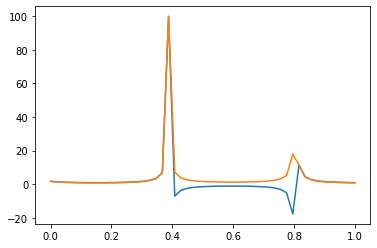

In [201]:
t = torch.linspace(0, 1, 50).unsqueeze(0)
y = f_HF(t)
qq = q(t)
plt.plot(t.squeeze(), y)
plt.plot(t.squeeze(), qq)

As $q(x)$ is 
\begin{align}
q(x) \propto \lvert f^{HF}(x)-\mu^{HF}\rvert p(x)
\end{align}

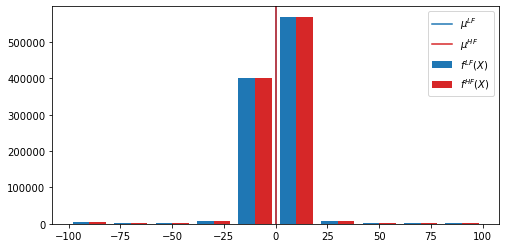

In [202]:
# evaluate ExL and ExH
x   = sample_p(int(1e6))
xL = f_LF(x)
xH = f_HF(x)
ExL = xL.mean().item()
ExH = xH.mean().item()
SxL = xL.std().item()
SxH = xH.std().item()

bound = torch.tensor([0, 1]) # range of inputs

# plot histograms of xL and xH
plt.figure(figsize=(8,4))
plt.hist([xL,xH],label=[r'$f^{LF}(X)$',r'$f^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.axvline(x = ExL, color = 'tab:blue', label = r'$\mu^{LF}$')
plt.axvline(x = ExH, color = 'tab:red', label = r'$\mu^{HF}$')
plt.legend()

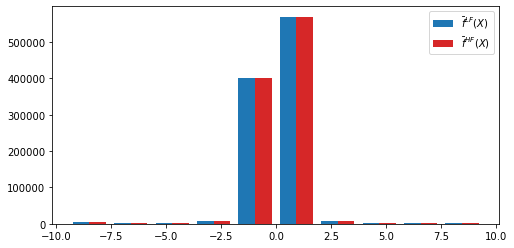

In [203]:
# plot histograms of normalized xL and xH
n_xL = (xL - ExL)/SxL
n_xH = (xH - ExH)/SxH

plt.figure(figsize=(8,4))
plt.hist([n_xL, n_xH],label=[r'$\bar{f}^{LF}(X)$',r'$\bar{f}^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.legend()

In [204]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# plot biasing density q(x)
def q(x):
    return torch.abs(f_LF(x) - ExL)

def get_inverted_cdf(xs, pdfs):
    cdfs = cumtrapz(pdfs, x=xs) # Get the CDF using a very fast trapz rule
    cdfs = cdfs / cdfs.max()  # Ensure its normalised, to cater for unnormalised PDFs
    cdfs = np.insert(cdfs, 0, 0)  # Add the 0 area to start of the CDF array
    return interp1d(cdfs, xs, kind="linear")  # return interpolation from cdf -> x
    
def sample_fn(fn, n=1):
    return fn(np.random.random(size=n))

In [205]:
xs = torch.linspace(0.0, 1.0, 1000).unsqueeze(1)
pdfs = q(xs).detach().numpy()
wgts = 1.0 / pdfs
xs = xs.squeeze().detach().numpy()
fn = get_inverted_cdf(xs, pdfs)
q_smps_1 = sample_fn(fn, n=100000)

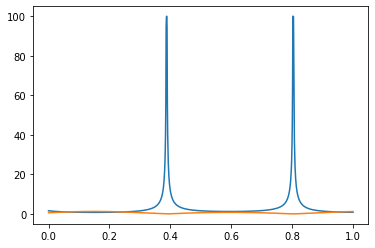

In [206]:
plt.plot(xs, pdfs, label='q(x)')
plt.plot(xs, wgts, label='w(x)')

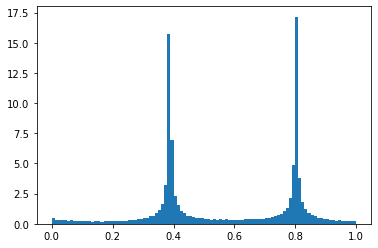

In [207]:
_ = plt.hist(q_smps_1, bins=100, density=True, label='q(x)')

In [267]:
# apply Langevin algorithm to sample from q(x)
from tqdm import tqdm
def potential(z): # evaluate the potential function for the given z
    return -torch.log(torch.abs(f_LF(z) - ExL))

# def unadjusted_langevin_algorithm(potential, iter_num=int(1e4), step=1e-4, burn_in=int(1e6)):
#     Z0 = sample_p(1)
#     Zi = Z0
#     samples = []
#     for i in tqdm(range(iter_num + burn_in)):
#         Zi.requires_grad_()
#         u = potential(Zi).mean()
#         grad = torch.autograd.grad(u, Zi)[0]
#         rejected = True
#         while rejected:
#             new_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1)
#             if (new_Zi < 1).all() and (new_Zi > 0).all():
#                 Zi = new_Zi
#                 rejected = False
#         samples.append(Zi.detach())
#     return torch.cat(samples, 0)[burn_in:]

def unadjusted_langevin_algorithm(potential,
            iter_num: int = int(1e5), # number of iterations as output
            step: float = 1e-2, # step size of Langevin algorithm
            burn_in: int = int(1e5), # number of MC burn-in iterations,
            num_thread: int = 10
            ):
    """
    This function implements the unadjusted Langevin algorithm
    for sampling biasing distribution q.
    """
    Z0 = sample_p(num_thread)
    Zi = Z0
    samples = []
    for i in tqdm(range(iter_num + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        rejected = True
        count = 0
        new_step = step if i < burn_in else step/50
        while rejected:
            new_Zi = Zi.detach() - new_step * grad + np.sqrt(2 * new_step) * torch.randn(1)
            if (new_Zi < 1).all() and (new_Zi > 0).all():
                Zi = new_Zi
                rejected = False
            else:
                count += 1
            if count > 10:
                new_step /= 2
                count = 0
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in*num_thread:]

In [272]:
q_smps_2 = unadjusted_langevin_algorithm(potential, iter_num=int(1e4), step=1e-2, burn_in=int(1e6), num_thread=10)

100%|██████████| 1010000/1010000 [3:32:56<00:00, 79.05it/s]  


Text(0.5, 1.0, 'Langevin algorithm')

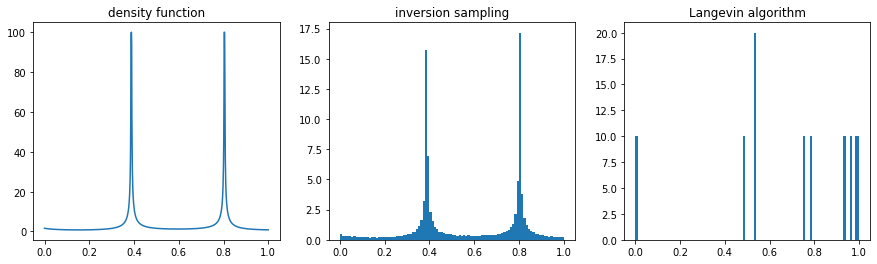

In [273]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
axs[0].plot(xs, pdfs)
axs[0].set_title('density function')
axs[1].hist(q_smps_1, bins=100, density=True)
axs[1].set_title('inversion sampling')
axs[2].hist(q_smps_2.detach().numpy(), bins=100, density=True)
axs[2].set_title('Langevin algorithm')
#fig.savefig('dim1-density-ell='+str(ell)+'.png', dpi=200)

In [226]:
def weight(xi): # evaluate the unnormalized weight for the given xi
    wt = 1/torch.abs(f_LF(xi)-ExL)
    return wt

In [227]:
x_q_lst = torch.from_numpy(q_smps_1).type(torch.FloatTensor)

MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
wt = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample_p(MC_N) # sample MC xi_p
        xi_q = x_q_lst[np.random.choice(len(x_q_lst),MC_N)] # sample xi_q
        wt_q = weight(xi_q)
        wt_q /= wt_q.sum()
        MC_est_lst.append(f_HF(xi_p).mean().item())
        IS_est_lst.append((wt_q * f_HF(xi_q)).sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean_1 = np.nanmean(MC, axis=0)
MC_std_1  = np.nanstd(MC, axis=0)
IS_mean_1 = np.nanmean(IS, axis=0)
IS_std_1  = np.nanstd(IS, axis=0)

Text(0.5, 1.0, 'Inversion Sampling')

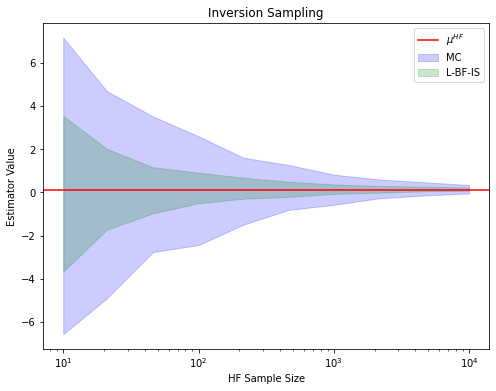

In [228]:
scale = 1.94
plt.figure(figsize=(8,6))
plt.fill_between(MC_N_lst, MC_mean_1-scale*MC_std_1, MC_mean_1+scale*MC_std_1,color='b',alpha=0.2,label='MC')
plt.fill_between(MC_N_lst, IS_mean_1-scale*IS_std_1, IS_mean_1+scale*IS_std_1,color='g',alpha=0.2,label='L-BF-IS')
plt.axhline(ExH,c='r',label=r'$\mu^{HF}$')
plt.xscale('log')
plt.xlabel('HF Sample Size')
plt.ylabel('Estimator Value')
plt.legend()
plt.title(r'Inversion Sampling')
# plt.savefig('dim1000-l-035.pdf',format='pdf',dpi=200)

In [274]:
x_q_lst = q_smps_2.reshape(100000, 1)

MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
wt = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample_p(MC_N) # sample MC xi_p
        xi_q = x_q_lst[np.random.choice(len(x_q_lst),MC_N)] # sample xi_q
        wt_q = weight(xi_q)
        wt_q /= wt_q.sum()
        MC_est_lst.append(f_HF(xi_p).mean().item())
        IS_est_lst.append((wt_q * f_HF(xi_q)).sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean_2 = np.nanmean(MC, axis=0)
MC_std_2  = np.nanstd(MC, axis=0)
IS_mean_2 = np.nanmean(IS, axis=0)
IS_std_2  = np.nanstd(IS, axis=0)

Text(0.5, 1.0, 'Langevin Algorithm')

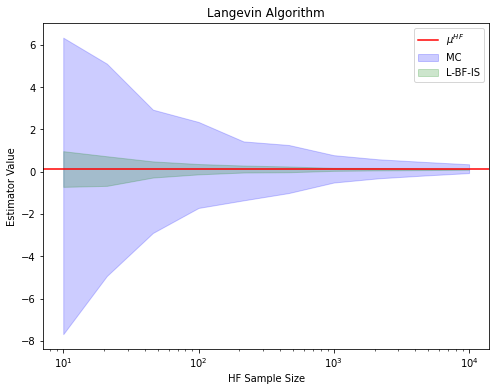

In [275]:
scale = 1.94
plt.figure(figsize=(8,6))
plt.fill_between(MC_N_lst, MC_mean_2-scale*MC_std_2, MC_mean_2+scale*MC_std_2,color='b',alpha=0.2,label='MC')
plt.fill_between(MC_N_lst, IS_mean_2-scale*IS_std_2, IS_mean_2+scale*IS_std_2,color='g',alpha=0.2,label='L-BF-IS')
plt.axhline(ExH,c='r',label=r'$\mu^{HF}$')
plt.xscale('log')
plt.xlabel('HF Sample Size')
plt.ylabel('Estimator Value')
plt.legend()
plt.title(r'Langevin Algorithm')
# plt.savefig('dim1000-l-035.pdf',format='pdf',dpi=200)

Text(0.5, 1.0, 'Langevin Algorithm')

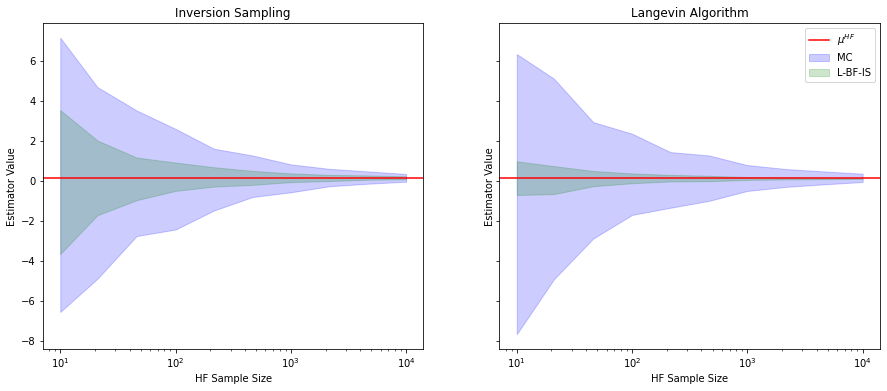

In [276]:
scale = 1.94
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

axs[0].fill_between(MC_N_lst, MC_mean_1-scale*MC_std_1, MC_mean_1+scale*MC_std_1,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean_1-scale*IS_std_1, IS_mean_1+scale*IS_std_1,color='g',alpha=0.2,label='L-BF-IS')
axs[0].axhline(ExH,c='r',label=r'$\mu^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].set_title(r'Inversion Sampling')

axs[1].fill_between(MC_N_lst, MC_mean_2-scale*MC_std_2, MC_mean_2+scale*MC_std_2,color='b',alpha=0.2,label='MC')
axs[1].fill_between(MC_N_lst, IS_mean_2-scale*IS_std_2, IS_mean_2+scale*IS_std_2,color='g',alpha=0.2,label='L-BF-IS')
axs[1].axhline(ExH,c='r',label=r'$\mu^{HF}$')
axs[1].set_xscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('Estimator Value')
plt.legend()
axs[1].set_title(r'Langevin Algorithm')
# fig.savefig('dim1-ell='+str(ell)+'.pdf',format='pdf',dpi=200)

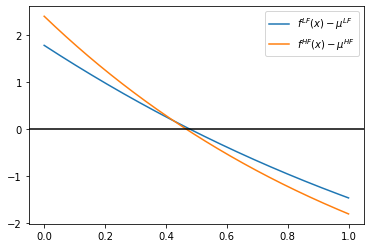

In [67]:
t = np.linspace(0, 1, 1000)
yL = f_LF(torch.Tensor(t).unsqueeze(1)).detach().numpy() - ExL
yH = f_HF(torch.Tensor(t).unsqueeze(1)).detach().numpy() - ExH
plt.plot(t, yL, label=r'$f^{LF}(x)-\mu^{LF}$')
plt.plot(t, yH, label=r'$f^{HF}(x)-\mu^{HF}$')
plt.axhline(0, c='k')
plt.legend()
# plt.savefig('temp.png', dpi=200)

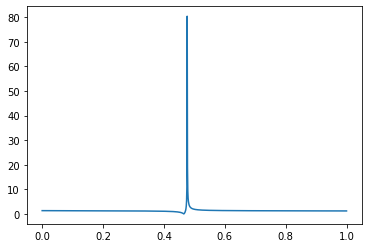

In [68]:
C = np.abs(yH/yL)
plt.plot(t, C)

In [213]:
import scipy

def lf(x):
    return f_LF(torch.Tensor(x).unsqueeze(1)).detach().numpy() - ExL
def hf(x):
    return f_HF(torch.Tensor(x).unsqueeze(1)).detach().numpy() - ExH

(0.0, 10.0)

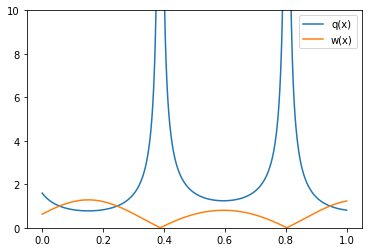

In [197]:
cbound = 100
def f(xi):
    return (1/(torch.sin(2.25*np.pi*xi+0.5)+0.1)).squeeze().clamp(min=-cbound, max=cbound)

E = f(sample_p(int(1e6))).mean().item()

q = lambda x: torch.abs(f(x) - E)
weight = lambda x: 1/torch.abs(f(x) - E)

xs = torch.linspace(0.0, 1.0, 1000).unsqueeze(1)
pdfs = q(xs).detach().numpy()
wgts = 1.0 / pdfs
xs = xs.squeeze().detach().numpy()
fn = get_inverted_cdf(xs, pdfs)
q_smps_1 = sample_fn(fn, n=100000)

plt.plot(xs, pdfs, label='q(x)')
plt.plot(xs, wgts, label='w(x)')
plt.legend()
plt.ylim(0, 10)

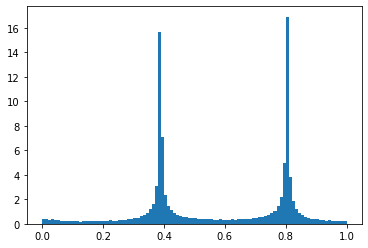

In [198]:
_ = plt.hist(q_smps_1, bins=100, density=True, label='q(x)')

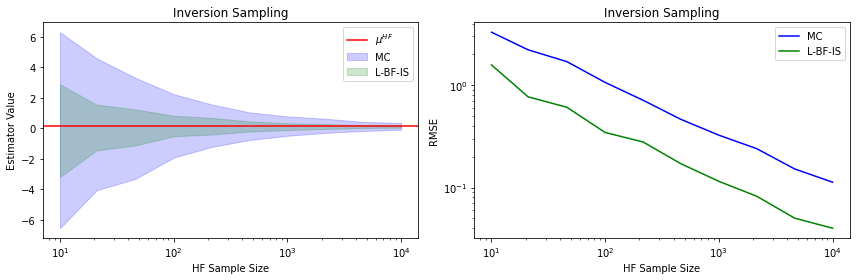

In [199]:
x_q_lst = torch.from_numpy(q_smps_1).type(torch.FloatTensor)

MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    wt_lst     = []
    for MC_N in MC_N_lst:
        xi_p = sample_p(MC_N) # sample MC xi_p
        xi_q = x_q_lst[np.random.choice(len(x_q_lst),MC_N)] # sample xi_q
        wt_q = weight(xi_q)
        wt_q /= wt_q.sum()
        MC_est_lst.append(f(xi_p).mean().item())
        IS_est_lst.append((wt_q * f(xi_q)).sum().item())
        wt_lst.append(wt_q)
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean_1 = np.nanmean(MC, axis=0)
MC_std_1  = np.nanstd(MC, axis=0)
IS_mean_1 = np.nanmean(IS, axis=0)
IS_std_1  = np.nanstd(IS, axis=0)
MC_err    = ((MC - E)**2)
IS_err    = ((IS - E)**2)
MC_rmse   = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse   = np.sqrt(np.nanmean(IS_err, axis=0))

# scale = 1.94
# plt.figure(figsize=(8,6))
# plt.fill_between(MC_N_lst, MC_mean_1-scale*MC_std_1, MC_mean_1+scale*MC_std_1,color='b',alpha=0.2,label='MC')
# plt.fill_between(MC_N_lst, IS_mean_1-scale*IS_std_1, IS_mean_1+scale*IS_std_1,color='g',alpha=0.2,label='L-BF-IS')
# plt.axhline(E,c='r',label=r'$\mu^{HF}$')
# plt.xscale('log')
# plt.xlabel('HF Sample Size')
# plt.ylabel('Estimator Value')
# plt.legend()
# plt.title(r'Inversion Sampling')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
scale = 1.96

axs[0].fill_between(MC_N_lst, MC_mean_1-scale*MC_std_1, MC_mean_1+scale*MC_std_1,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean_1-scale*IS_std_1, IS_mean_1+scale*IS_std_1,color='g',alpha=0.2,label='L-BF-IS')
axs[0].axhline(E,c='r',label=r'$\mu^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(r'Inversion Sampling')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(r'Inversion Sampling')

fig.tight_layout()
plt.show()

In [59]:
x_q_lst

tensor([0.3581, 0.1488, 0.0482,  ..., 0.4046, 0.0060, 0.3736])